In [131]:
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/dataquestio/project-walkthroughs/master/prophet_weather/weather.csv'
weather = pd.read_csv(url, index_col="DATE")

In [132]:
weather.head()

,STATION,NAME,ACMH,ACSH,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,...,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WV01,WV20
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-01,USW00014732,"LAGUARDIA AIRPORT, NY US",80.0,90.0,NaN,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-02,USW00014732,"LAGUARDIA AIRPORT, NY US",20.0,20.0,NaN,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-03,USW00014732,"LAGUARDIA AIRPORT, NY US",90.0,100.0,NaN,NaN,NaN,0.05,0.4,0.0,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1970-01-04,USW00014732,"LAGUARDIA AIRPORT, NY US",20.0,20.0,NaN,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,USW00014732,"LAGUARDIA AIRPORT, NY US",30.0,10.0,NaN,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
##CLEAN DATA##

#We will get rid of the NAN's (missing data)
#Apply the isnull to each column with apply(pd.isnull)
null_pct = weather.apply(pd.isnull).sum()/ weather.shape[0]

valid_columns = weather.columns[null_pct < .05]

weather = weather[valid_columns].copy()

weather.columns = weather.columns.str.lower()

weather.index = pd.to_datetime(weather.index)

In [134]:
weather['station'].unique()

array(['USW00014732', 'USW00094789'], dtype=object)

In [135]:
##Split THE DATA##

#Data from both stations will show up in a single row
#Makes data easier to work with
lga = weather[weather['station'] == 'USW00014732'].copy()
#Now row count is about half of origional
weather = weather[weather['station'] == 'USW00094789'].copy()
#If you check this code now we have two dataframes (one for JKF one for LGA)

weather = weather.merge(lga, left_index=True, right_index=True)
#Now we have 14 columns and 19000 rows and columns have been renames


In [136]:
##SETUP FOR ALGORITHM##

#shift tmax_x column back 1 day
#y is now tomorrows temp(tmax_x is todays temp, y is tommorows temp)
weather['y'] = weather.shift(-1)['tmax_x']

#Fill in any missing values using ffill(forward fill)
#makes it easier to forcast
weather = weather.ffill()

#Create new column ds (date of each observation)
weather['ds'] = weather.index

#Create a list of predictors
predictors = weather.columns[~weather.columns.isin(['y','name_x', 'station_x', 'name_y', 
                                                    'station_y', 'ds'])]

#Create train and test sets at specific dates
train = weather[:'2021-12-31']
test = weather['2021-12-31':]

In [137]:
##Run Prophet for 2022##

#Use prophet to make predictions (import prophet)
from prophet import Prophet

#create a function called fit_prophet to take in train dataset
def fit_prophet(train):
    m = Prophet()
    for p in predictors:
        m.add_regressor(p)
    m.fit(train)
    return m

m = fit_prophet(train)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpec2gq8s_/ptmon6we.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpec2gq8s_/6935cu4_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89380', 'data', 'file=/tmp/tmpec2gq8s_/ptmon6we.json', 'init=/tmp/tmpec2gq8s_/6935cu4_.json', 'output', 'file=/tmp/tmpec2gq8s_/prophet_models99cgz7i/prophet_model-20221129141424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:14:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:14:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [138]:
predictions = m.predict(test)
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-31,61.461584,43.559356,58.894111,61.461584,61.461584,-10.170250,-10.170250,-10.170250,-2.405725,...,0.024404,0.024404,0.024404,-7.788929,-7.788929,-7.788929,0.0,0.0,0.0,51.291334
1,2022-01-01,61.461365,44.442925,60.100175,61.461365,61.461365,-9.474061,-9.474061,-9.474061,-1.625848,...,-0.016459,-0.016459,-0.016459,-7.831755,-7.831755,-7.831755,0.0,0.0,0.0,51.987304
2,2022-01-02,61.461146,42.160154,56.942105,61.461146,61.461146,-11.881656,-11.881656,-11.881656,-4.101412,...,0.092267,0.092267,0.092267,-7.872511,-7.872511,-7.872511,0.0,0.0,0.0,49.579490
3,2022-01-03,61.460927,30.874326,45.868060,61.460927,61.460927,-22.893355,-22.893355,-22.893355,-15.310052,...,0.327926,0.327926,0.327926,-7.911229,-7.911229,-7.911229,0.0,0.0,0.0,38.567572
4,2022-01-04,61.460708,28.640665,43.930080,61.460708,61.460708,-25.300376,-25.300376,-25.300376,-17.259664,...,-0.092781,-0.092781,-0.092781,-7.947932,-7.947932,-7.947932,0.0,0.0,0.0,36.160331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,2022-11-13,61.392158,48.800258,64.757862,61.376138,61.405465,-5.038102,-5.038102,-5.038102,-2.145346,...,0.092267,0.092267,0.092267,-2.985023,-2.985023,-2.985023,0.0,0.0,0.0,56.354055
318,2022-11-14,61.391939,43.193445,58.147707,61.375733,61.405227,-11.144470,-11.144470,-11.144470,-8.349572,...,0.327926,0.327926,0.327926,-3.122824,-3.122824,-3.122824,0.0,0.0,0.0,50.247469
319,2022-11-15,61.391720,41.865887,57.069297,61.375327,61.405154,-12.081189,-12.081189,-12.081189,-8.728431,...,-0.092781,-0.092781,-0.092781,-3.259977,-3.259977,-3.259977,0.0,0.0,0.0,49.310531
320,2022-11-16,61.391500,42.945954,58.383257,61.374931,61.404986,-10.701470,-10.701470,-10.701470,-7.042954,...,-0.262115,-0.262115,-0.262115,-3.396401,-3.396401,-3.396401,0.0,0.0,0.0,50.690030


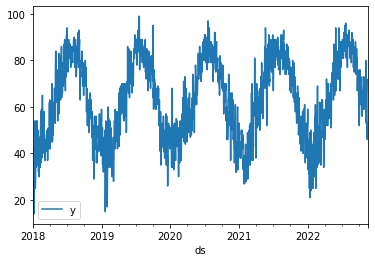

In [139]:
weather['2018-01-01':].plot('ds', 'y')
#Outcome:
#The graph shows our temperature over time
#(From 2018 to the present)
#There is a strong pattern(Summer=High Temps, Winter=Low Temps) which repreats overtime (Seasonal Pattern)

In [140]:
#
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric

plot_components_plotly(m, predictions)

#Outcome:
#Prophet seperates timesieries into different pattern
#(Tries to predict each trend seperatly then adds them together for a final prediction)

#Trend: The general trend in temperature over time

#Extra Regressors: All of the extra columns added during coding process

#Yearly: Annual trend in temp

#Weekly: a broken down trend for a daily temperature each week
#(may not neccesarly be accurate)

In [141]:
#Now we look at importance of columns to preophets predictions
from prophet.utilities import regressor_coefficients

regressor_coefficients(m)

#Outcome:
#Running regressor_coefs on trained prophet model
#shows the predicted change in each column

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,prcp_x,additive,0.118130,-0.196123,-0.196123,-0.196123
1,snow_x,additive,0.064540,-0.010792,-0.010792,-0.010792
2,snwd_x,additive,0.209635,0.064181,0.064181,0.064181
3,tmax_x,additive,61.758648,0.012567,0.012567,0.012567
4,tmin_x,additive,47.494024,-0.083048,-0.083048,-0.083048
5,prcp_y,additive,0.123378,-0.322177,-0.322177,-0.322177
6,snow_y,additive,0.071347,-0.492263,-0.492263,-0.492263
7,snwd_y,additive,0.217759,-0.202091,-0.202091,-0.202091
8,tmax_y,additive,62.609277,0.281345,0.281345,0.281345
9,tmin_y,additive,48.923130,0.426440,0.426440,0.426440


In [142]:
#Checking Means Sq Error
#First: Match predictions index to test index
#Second create a column 'actual' that has the actual values from test set
predictions.index = test.index
predictions['actual'] = test['y']

#write a function 'meanssqerror' that takes in:
#predictions, labels for actual values, label for prediction values
def mse(predictions, actual_label='actual', pred_label='yhat'):
  se = ((predictions[actual_label] - predictions[pred_label]) ** 2)
  print(se.mean())

mse(predictions)

40.51864281184951


In [143]:
##CROSS VALIDATION##
#Validate across whole dataset
from prophet.diagnostics import cross_validation

m = fit_prophet(weather)
cv = cross_validation(m, initial=f'{365 * 5} days', period='180 days', horizon='180 days', parallel='processes')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpec2gq8s_/gahvbxtz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpec2gq8s_/ynbrtve_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42382', 'data', 'file=/tmp/tmpec2gq8s_/gahvbxtz.json', 'init=/tmp/tmpec2gq8s_/ynbrtve_.json', 'output', 'file=/tmp/tmpec2gq8s_/prophet_modeliy5n5y_h/prophet_model-20221129141438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:14:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:14:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 97 forecasts with cutoffs between 1975-01-28 00:00:00 and 2022-05-21 00:00:00
INFO:prophet:Applying in parallel with <concu

In [144]:
#Using MSE function to pass in our cross validated results and our actual label
#to get MSE
mse(cv, actual_label='y')

36.18290389742088


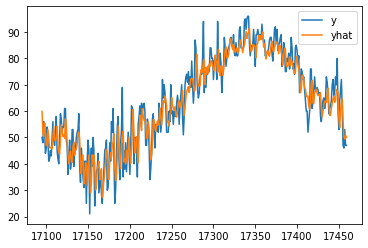

In [146]:
#Plot our 'y' and 'y_hat' for the last 365 days
cv[['y', 'yhat']][-365:].plot()

#Outcome:
#We can see our actual 'y' value and our predicted 'y' value
#Our predicted 'y' value correlated and follows the trend well
#There are spikes in temp the model doesnt know about(Not enough information)

In [147]:
##Make FUTURE PREDICTIONS##
#Use model to predict 1 day ahead
m = fit_prophet(weather)
m.predict(weather.iloc[-1:])

#Outcome:
#Predicting that itll be 50 degrees the next day

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpec2gq8s_/4_0fukj3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpec2gq8s_/b5_5kbpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76166', 'data', 'file=/tmp/tmpec2gq8s_/4_0fukj3.json', 'init=/tmp/tmpec2gq8s_/b5_5kbpb.json', 'output', 'file=/tmp/tmpec2gq8s_/prophet_modelw3z1w4p3/prophet_model-20221129142737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:27:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-11-17,61.677854,41.899028,57.87406,61.677854,61.677854,-11.530414,-11.530414,-11.530414,-7.903977,...,-0.065254,-0.065254,-0.065254,-3.561183,-3.561183,-3.561183,0.0,0.0,0.0,50.14744


In [148]:
#Less accurate prediction but multiple days ahead of time
m = Prophet()
m.fit(weather)
#Used to create dataframes for the next number of days (365 days)
future = m.make_future_dataframe(periods=365)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpec2gq8s_/xotorwdc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpec2gq8s_/cjhqxram.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41383', 'data', 'file=/tmp/tmpec2gq8s_/xotorwdc.json', 'init=/tmp/tmpec2gq8s_/cjhqxram.json', 'output', 'file=/tmp/tmpec2gq8s_/prophet_model5ffqp09n/prophet_model-20221129142800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:28:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [151]:
#Plot predictions for a full year ahead
forecast = m.predict(future)

plot_plotly(m, forecast)

#Outcome:
#Black dots are actual values!
#Blue dots are predicted values!
#Less acurate farther out you go!

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
submission = pd.DataFrame({'status_results': y_preds}, index=X_test.index)
submission